In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.float64)

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.sampling import draw_sobol_samples

## Multi-objective (two functions)

Two functions are created by using 2 GPs to fit a sine and a cosine function separately (with noise). We use the obtained GP posterior means as our objective functions.

In [2]:
bounds = torch.tensor([[-3.], [3.]])

In [3]:
def sin(x, noise=True):
    if noise:
        return torch.sin(x*2*torch.pi) + torch.rand(x.shape)
    else:
        return torch.sin(x*2*torch.pi)

def cos(x, noise=True):
    if noise:
        return torch.cos(x*2*torch.pi) + torch.rand(x.shape)
    else:
        return torch.cos(x*2*torch.pi)

### Create objective functions via GPs

In [4]:
x1_observed = np.random.uniform(*bounds, 20).reshape(-1, 1)
x1_observed = torch.tensor(x1_observed)
y1_observed = sin(x1_observed)

x2_observed = np.random.uniform(*bounds, 20).reshape(-1, 1)
x2_observed = torch.tensor(x2_observed)
y2_observed = cos(x2_observed)

x_dense = np.linspace(*bounds, 1000).reshape(-1, 1)
x_dense = torch.tensor(x_dense)

In [5]:
gp1 = SingleTaskGP(x1_observed, y1_observed)
mll1 = ExactMarginalLogLikelihood(gp1.likelihood, gp1)
fit_gpytorch_mll(mll1)
with torch.no_grad():
    gp1_posterior = gp1.posterior(x_dense)

In [6]:
gp2 = SingleTaskGP(x2_observed, y2_observed)
mll2 = ExactMarginalLogLikelihood(gp2.likelihood, gp2)
fit_gpytorch_mll(mll2)
with torch.no_grad():
    gp2_posterior = gp2.posterior(x_dense)

### Find non-dominated points (pareto front)

In [7]:
y_dense= torch.stack([gp1_posterior.mean, gp2_posterior.mean]).T
pareto = is_non_dominated(y_dense)

y1_pareto = []
y2_pareto = []
for n, p in enumerate(pareto[0]):
    y1_pareto.append(gp1_posterior.mean.numpy()[n].item() if p else np.nan)
    y2_pareto.append(gp2_posterior.mean.numpy()[n].item() if p else np.nan)

/tmp/ipykernel_4040797/1904577359.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352595413/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  y_dense= torch.stack([gp1_posterior.mean, gp2_posterior.mean]).T


### Visualize pareto front

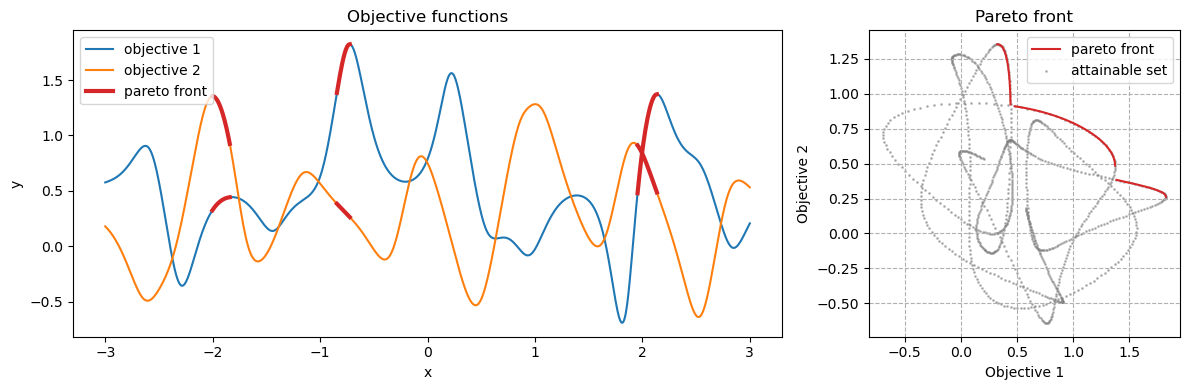

In [18]:
plt.figure(figsize=(12, 4))
ax_func = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax_func.plot(x_dense, gp1_posterior.mean, label="objective 1")
ax_func.plot(x_dense, gp2_posterior.mean, label="objective 2")
ax_func.plot(x_dense, y1_pareto, color='tab:red', linewidth=3, label="pareto front")
ax_func.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.legend()

ax_pareto = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
ax_pareto.scatter(gp1_posterior.mean, gp2_posterior.mean, color='gray', s=1,label='attainable set', alpha=.5)
ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1")
ax_pareto.set_ylabel("Objective 2")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()

## Multiobjective BO via expected hypervolume improvement (EHVI)

In [9]:
num_init = 20
x_observed = draw_sobol_samples(bounds=bounds, n=num_init, q=1).squeeze(1)

with torch.no_grad():
    y1 = gp1.posterior(x_observed).mean.squeeze()
    y2 = gp2.posterior(x_observed).mean.squeeze()

y_observed = torch.stack([y1, y2]).T

### Initial observations

In [10]:
# compute hypervolume
ref_point=torch.tensor([-2., -2])
bd = DominatedPartitioning(ref_point=ref_point, Y=y_observed)
volume = bd.compute_hypervolume().item()

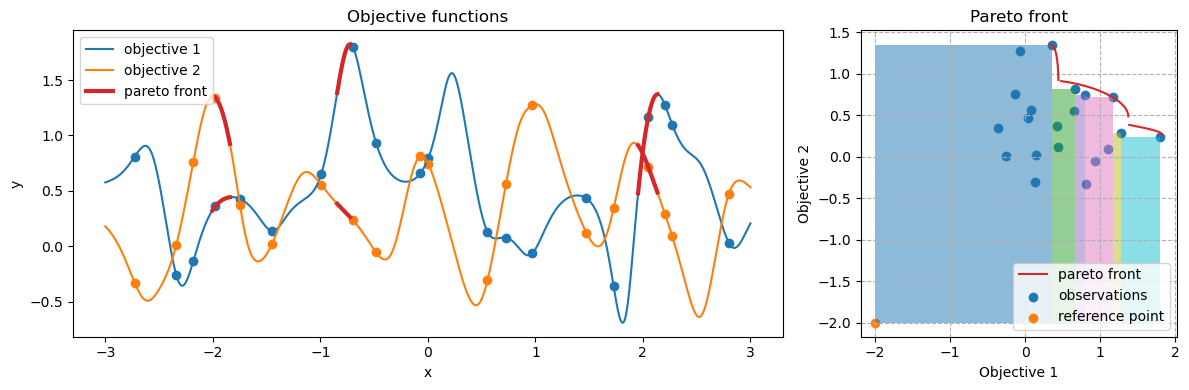

In [11]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 4))
ax_func = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax_func.plot(x_dense, gp1_posterior.mean, label="objective 1")
ax_func.plot(x_dense, gp2_posterior.mean, label="objective 2")
ax_func.plot(x_dense, y1_pareto, color='tab:red', linewidth=3, label="pareto front")
ax_func.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
ax_func.scatter(x_observed, y1, color="tab:blue")
ax_func.scatter(x_observed, y2, color="tab:orange")
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.legend()

ax_pareto = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
ax_pareto.scatter(*y_observed.T, label="observations")
ax_pareto.scatter(*ref_point, label="reference point")

l = bd.hypercell_bounds[0]
u = bd.hypercell_bounds[1]
boxes = [Rectangle(
    l_point,
    *(u_point - l_point),
) for l_point, u_point in zip(l, u)]
pc = PatchCollection(boxes, cmap='tab10', alpha=.5)
pc.set_array(np.arange(0, len(l)))
ax_pareto.add_collection(pc)

ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1")
ax_pareto.set_ylabel("Objective 2")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()